In [34]:
import ngsolve as ngs
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw
from ngsolve.krylovspace import CGSolver
from ttictoc import tic, toc

mesh = ngs.Mesh('whatever.vol')
mesh.Curve(2)
# mesh.Refine()

In [35]:
%run J.ipynb

using 3d mesh with ne= 494988  elements and nv= 85316  points
Solving...
... Success!
Number of iterations = 558/1000 | Residual = 9.935128322942854e-06
999.9999999999959
Solving...
... Success!
Number of iterations = 641/1000 | Residual = 9.9234432391929e-06
1000.0003712683572


In [36]:
from bhdata import BHCurves
fun_dw  = BHCurves(4)
fun_w   = fun_dw.Integrate()
fun_ddw = fun_dw.Differentiate()

mu0 = 1.256636e-6
nu0 = 1/mu0

linear = "coil|ambient|default"
nonlinear = "r_steel|l_steel|mid_steel"

BH data from TEAM 13 problem
returning energy


In [37]:
# print(HCurl.ndof)
# print(mesh.GetMaterials())

p = 1

HCurl = ngs.HCurl(mesh, order = p, nograds = True)
u,v = HCurl.TnT()


# Nonlinear:

maxit = 10000
tol2 = 1e-8
regb = 1e-12

A = ngs.GridFunction(HCurl)
B = ngs.curl(A)
normB = ngs.sqrt(B*B + regb)



cf_energy = mesh.MaterialCF({linear: nu0/2*B*B, nonlinear: fun_w(normB)}, default = nu0/2*B*B).Compile()
def fun_W():
    with ngs.TaskManager(): res = ngs.Integrate(cf_energy - Hs*ngs.curl(A), mesh)
    return res



cf_rhs = mesh.MaterialCF({linear: nu0, nonlinear: fun_dw(normB)/normB}, default = nu0).Compile()
# Draw(mu_nl, mesh)
# rhs = ngs.LinearForm(- (Hs*ngs.curl(v))*ngs.dx)
# rhs = ngs.LinearForm(- (ngs.curl(Hs)*v)*ngs.dx)
rhs = ngs.LinearForm((cf_rhs*B*ngs.curl(v) - Hs*ngs.curl(v))*ngs.dx)

def fun_dW(): #implicitly depending on A!
    with ngs.TaskManager(): rhs.Assemble()
    return rhs


Id = ngs.CF((1,0,0,
             0,1,0,
             0,0,1), dims=(3,3))

BBt = ngs.CF((B[0]*B[0], B[0]*B[1], B[0]*B[2],
              B[1]*B[0], B[1]*B[1], B[1]*B[2],
              B[2]*B[0], B[2]*B[1], B[2]*B[2]), dims = (3,3))


fun1 = fun_dw(normB)/normB
fun2 = (fun_ddw(normB) - fun_dw(normB)/normB)/(normB*normB)

cf_iter = mesh.MaterialCF({linear: nu0*Id, nonlinear: fun1*Id + fun2*BBt}, default = nu0*Id).Compile()

K_iter = ngs.BilinearForm(HCurl)
K_iter += (cf_iter*ngs.curl(u)*ngs.curl(v))*ngs.dx
C_iter = ngs.Preconditioner(K_iter, type = "local")

def fun_ddW():
    with ngs.TaskManager(): K_iter.Assemble()
    return K_iter


In [38]:
print("Using 3D mesh with ne=", mesh.ne, "elements and nv=", mesh.nv, "points and " ,HCurl.ndof, "DOFs.\n ")

with ngs.TaskManager(): A.Set(ngs.CF((0,0,0)))

du = ngs.GridFunction(HCurl)
uo = ngs.GridFunction(HCurl)
wo = 1e12

for it in range(1,maxit+1):
    tic()
    # with ngs.TaskManager():
    #     K_iter.Assemble()
    #     rhs.Assemble()
    #     res = ngs.Integrate(cf_energy - Hs*ngs.curl(A), mesh)
    
    w  = fun_W()
    dw = fun_dW()
    da = fun_ddW()
    tm1 = toc()
    
    tic()
    # du.vec.data = da.mat.Inverse(HCurl.FreeDofs(), inverse="sparsecholesky") * dw.vec 
    # iterativeSolver = CGSolver(K_iter.mat, freedofs = HCurl.FreeDofs(), atol = 1e-2,  maxiter = maxit, printrates = False)
    with ngs.TaskManager():
        iterativeSolver = CGSolver(K_iter.mat, pre = C_iter.mat, tol  = 1e-2,  maxiter = maxit)
        du.vec.data = iterativeSolver * dw.vec 
    
    if len(iterativeSolver.residuals) == maxit: print("... Success!")
    # print(f"Number of iterations = {iterativeSolver.iterations}/{maxit} | Residual = {iterativeSolver.residuals[-1]}")
    tm2 = toc()

    nrm = ngs.InnerProduct(du.vec,dw.vec)
    
    if it == 1:
        nrm0 = nrm
    
    # wn = 1e12
    # if abs(wn-w) < tol2:
    if nrm/nrm0 < tol2:
        print("converged to desired tolerance")
        break
    elif abs(wo-w) < tol2*1e-2:
        print("stopped early due to stagnation")
        break
    else:
        # linesearch
        uo.vec.data = A.vec.data
        wo = w
        alpha = 1
        for init in range(1,21):
            A.vec.data -= alpha*du.vec.data
            wn = fun_W()
            if wn < w - alpha*0.1*nrm:
                print("Iter: %2d | assem : %.2fs | CG took %.2fs with %4d iterations | alpha : %.2f | energy = %.10f | relres = %.2e |"  %(it,tm1,tm2,iterativeSolver.iterations,alpha,w,nrm/nrm0))
                break
            else:
                alpha = alpha/2
                A.vec.data = uo.vec.data

Using 3D mesh with ne= 494988 elements and nv= 85316 points and  580733 DOFs.
 
Iter:  1 | assem : 1.65s | CG took 0.69s with  151 iterations | alpha : 1.00 | energy = 0.0000000000 | relres = 1.00e+00 |
Iter:  2 | assem : 1.29s | CG took 1.64s with  430 iterations | alpha : 1.00 | energy = -0.1332617922 | relres = 8.25e-01 |
Iter:  3 | assem : 1.34s | CG took 0.54s with  119 iterations | alpha : 1.00 | energy = -0.2017832001 | relres = 1.42e-01 |
Iter:  4 | assem : 1.67s | CG took 0.68s with  160 iterations | alpha : 1.00 | energy = -0.2191054049 | relres = 1.24e-02 |
Iter:  5 | assem : 1.43s | CG took 0.18s with   43 iterations | alpha : 1.00 | energy = -0.2207015378 | relres = 4.53e-03 |
Iter:  6 | assem : 1.39s | CG took 0.56s with  128 iterations | alpha : 1.00 | energy = -0.2212880783 | relres = 8.47e-04 |
Iter:  7 | assem : 1.39s | CG took 0.66s with  162 iterations | alpha : 0.50 | energy = -0.2213899066 | relres = 1.63e-04 |
Iter:  8 | assem : 1.33s | CG took 0.66s with  163 it

1.5668634221796363


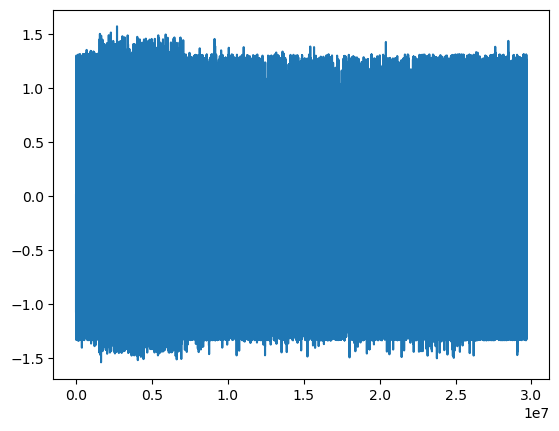

In [39]:
L2 = ngs.L2(mesh, dim=3, order = 3)
BB = ngs.GridFunction(L2)

with ngs.TaskManager(): BB.Set(B)
BBnp = BB.vec.FV().NumPy()
# HCurl.ndof

Avec = A.vec.FV().NumPy()


import matplotlib.pyplot as plt
import numpy as np

print(max(abs(BBnp)))
# print(BBnp.size,mesh.ne)

plt.plot((BBnp))

In [40]:
# Draw(B, mesh, clipping={"z":-1, "dist":0.064})
mesh.ne
(Bl2np.size)/(mesh.ne)

30.0

In [41]:
Bl2np

array([ 1.30020580e-02,  3.65819319e-19, -3.12922714e-19, ...,
       -3.11064207e-19,  3.93732630e-19,  1.41642268e-18])